<a href="https://colab.research.google.com/github/KatieMarsh/STONK/blob/main/Copy_of_stock_prediction_LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load and preprocess data**

In [1]:
#!pip install bta-lib #try this out

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

!pip install pandas_datareader
from pandas_datareader import data as pdr
from tqdm import tqdm_notebook

stock_list = ['SCC']
stock_data = []
stock_name = []
for quote in tqdm_notebook(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='2010-01-01', end='2021-06-17'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [3]:
stock_data[0].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,236.0,232.0,236.0,233.0,877400.0,155.559265
2010-01-05,236.0,231.0,235.0,233.0,1117100.0,155.559265
2010-01-06,234.0,229.0,233.0,230.0,1167600.0,153.556381
2010-01-07,231.0,225.0,231.0,226.0,1832200.0,150.885803
2010-01-08,230.0,225.0,226.0,227.0,2917000.0,151.553467


In [4]:
stock_data[0]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,236.0,232.0,236.0,233.0,877400.0,155.559265
2010-01-05,236.0,231.0,235.0,233.0,1117100.0,155.559265
2010-01-06,234.0,229.0,233.0,230.0,1167600.0,153.556381
2010-01-07,231.0,225.0,231.0,226.0,1832200.0,150.885803
2010-01-08,230.0,225.0,226.0,227.0,2917000.0,151.553467
...,...,...,...,...,...,...
2021-06-14,430.0,422.0,430.0,426.0,1334800.0,426.000000
2021-06-15,424.0,420.0,422.0,420.0,1988500.0,420.000000
2021-06-16,426.0,420.0,420.0,422.0,1123800.0,422.000000


In [5]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
dataset = stock_data[0]
dataset = dataset.drop('Close',axis=1)
dataset['pct_change'] = dataset['Adj Close'].pct_change().dropna()
values = dataset.values
values = values.astype('float32')

# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  
# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 30, 1,feat_name=dataset.columns)
reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)'],
              axis=1,inplace=True)

In [6]:
reframed.head(10)

,High(t-30),Low(t-30),Open(t-30),Volume(t-30),Adj Close(t-30),pct_change(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),Adj Close(t-29),pct_change(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),Adj Close(t-28),pct_change(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),Adj Close(t-27),pct_change(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),Adj Close(t-26),pct_change(t-26),High(t-25),Low(t-25),Open(t-25),Volume(t-25),Adj Close(t-25),pct_change(t-25),High(t-24),Low(t-24),Open(t-24),Volume(t-24),Adj Close(t-24),pct_change(t-24),High(t-23),Low(t-23),Open(t-23),Volume(t-23),Adj Close(t-23),pct_change(t-23),High(t-22),Low(t-22),Open(t-22),Volume(t-22),Adj Close(t-22),pct_change(t-22),High(t-21),Low(t-21),Open(t-21),Volume(t-21),Adj Close(t-21),pct_change(t-21),High(t-20),Low(t-20),Open(t-20),Volume(t-20),Adj Close(t-20),pct_change(t-20),High(t-19),Low(t-19),Open(t-19),Volume(t-19),Adj Close(t-19),pct_change(t-19),High(t-18),Low(t-18),Open(t-18),Volume(t-18),Adj Close(t-18),pct_change(t-18),High(t-17),Low(t-17),Open(t-17),Volume(t-17),Adj Close(t-17),pct_change(t-17),High(t-16),Low(t-16),Open(t-16),Volume(t-16),Adj Close(t-16),pct_change(t-16),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-15),pct_change(t-15),High(t-14),Low(t-14),Open(t-14),Volume(t-14),Adj Close(t-14),pct_change(t-14),High(t-13),Low(t-13),Open(t-13),Volume(t-13),Adj Close(t-13),pct_change(t-13),High(t-12),Low(t-12),Open(t-12),Volume(t-12),Adj Close(t-12),pct_change(t-12),High(t-11),Low(t-11),Open(t-11),Volume(t-11),Adj Close(t-11),pct_change(t-11),High(t-10),Low(t-10),Open(t-10),Volume(t-10),Adj Close(t-10),pct_change(t-10),High(t-9),Low(t-9),Open(t-9),Volume(t-9),Adj Close(t-9),pct_change(t-9),High(t-8),Low(t-8),Open(t-8),Volume(t-8),Adj Close(t-8),pct_change(t-8),High(t-7),Low(t-7),Open(t-7),Volume(t-7),Adj Close(t-7),pct_change(t-7),High(t-6),Low(t-6),Open(t-6),Volume(t-6),Adj Close(t-6),pct_change(t-6),High(t-5),Low(t-5),Open(t-5),Volume(t-5),Adj Close(t-5),pct_change(t-5),High(t-4),Low(t-4),Open(t-4),Volume(t-4),Adj Close(t-4),pct_change(t-4),High(t-3),Low(t-3),Open(t-3),Volume(t-3),Adj Close(t-3),pct_change(t-3),High(t-2),Low(t-2),Open(t-2),Volume(t-2),Adj Close(t-2),pct_change(t-2),High(t-1),Low(t-1),Open(t-1),Volume(t-1),Adj Close(t-1),pct_change(t-1),pct_change(t)
31,0.067449,0.059701,0.068047,0.026604,0.044091,0.421901,0.061584,0.053731,0.062130,0.027807,0.038079,0.370543,0.052786,0.041791,0.056213,0.043635,0.030062,0.352528,0.049853,0.041791,0.041420,0.069470,0.032066,0.439551,0.067449,0.050746,0.047337,0.097251,0.050104,0.580051,0.064516,0.056716,0.065089,0.043628,0.040083,0.337389,0.061584,0.053731,0.050296,0.041156,0.044091,0.456438,0.061584,0.059701,0.065089,0.019212,0.040083,0.387661,0.058651,0.050746,0.059172,0.041287,0.034070,0.370099,0.046921,0.044776,0.047337,0.029498,0.032066,0.404406,0.043988,0.038806,0.044379,0.040444,0.028058,0.386756,0.041056,0.032836,0.041420,0.025183,0.028058,0.421901,0.035191,0.029851,0.035503,0.021979,0.022046,0.368715,0.035191,0.023881,0.026627,0.032565,0.028058,0.475805,0.020528,0.014925,0.023669,0.076777,0.010021,0.262347,0.017595,0.014925,0.014793,0.020098,0.012025,0.440366,0.023460,0.011940,0.017751,0.049920,0.008017,0.385137,0.020528,0.011940,0.017751,0.038898,0.012025,0.459007,0.017595,0.011940,0.014793,0.024625,0.014029,0.440283,0.017595,0.008955,0.011834,0.022644,0.014029,0.421901,0.017595,0.011940,0.020710,0.039198,0.008017,0.367008,0.014663,0.011940,0.011834,0.046097,0.012025,0.459007,0.014663,0.014925,0.014793,0.008636,0.012025,0.421901,0.005865,0.005970,0.005917,0.021696,0.008017,0.385137,0.008798,0.002985,0.008876,0.015749,0.006012,0.403348,0.002933,0.00000,0.002959,0.023068,0.000000,0.365981,0.000000,0.000000,0.000000,0.020331,0.002004,0.440806,0.008798,0.005970,0.002959,0.017378,0.006012,0.459532,0.005865,0.005970,0.008876,0.018114,0.006012,0.421901,0.002933,0.000000,0.002959,0.011689,0.002004,0.384621,0.421901
32,0.061584,0.053731,0.062130,0.027807,0.038079,0.370543,0.052786,0.

In [7]:
# split into train and test sets
n_train_percent = 0.9
split = int(reframed.shape[0]*n_train_percent)
df_seq_train = reframed.iloc[:split, :]
df_seq_test = reframed.iloc[split:, :]

date_all = dataset.index[reframed.index]

## Extract features from datetime

In [8]:
df_dt = pd.DataFrame({'date_time':date_all})

In [9]:
df_dt_feat = pd.concat([df_dt.date_time.dt.day, df_dt.date_time.dt.dayofweek, df_dt.date_time.dt.dayofyear,\
                           df_dt.date_time.dt.daysinmonth, df_dt.date_time.dt.is_month_end,df_dt.date_time.dt.is_month_start,\
                           df_dt.date_time.dt.is_quarter_end, df_dt.date_time.dt.is_quarter_start, df_dt.date_time.dt.is_year_end,\
                           df_dt.date_time.dt.is_year_start],axis=1)
df_dt_feat.columns = ['day','dayofweek','dayofyear','daysinmonth','is_month_end','is_month_start','is_quarter_end','is_quarter_start',\
                        'is_year_end','is_year_start']

In [10]:
df_dt_feat['is_month_end'] = df_dt_feat['is_month_end'].astype(int)
df_dt_feat['is_month_start'] = df_dt_feat['is_month_start'].astype(int)
df_dt_feat['is_quarter_end'] = df_dt_feat['is_quarter_end'].astype(int)
df_dt_feat['is_quarter_start'] = df_dt_feat['is_quarter_start'].astype(int)
df_dt_feat['is_year_end'] = df_dt_feat['is_year_end'].astype(int)
df_dt_feat['is_year_start'] = df_dt_feat['is_year_start'].astype(int)

In [11]:
# encode categorical columns
for col in ['day','dayofweek','dayofyear','daysinmonth']:
  df_dt_feat[col] = df_dt_feat[col].astype('category').cat.as_ordered().cat.codes

In [12]:
df_dt_feat.head()

,day,dayofweek,dayofyear,daysinmonth,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,15,1,45,0,0,0,0,0,0,0
1,16,2,46,0,0,0,0,0,0,0
2,17,3,47,0,0,0,0,0,0,0
3,18,4,48,0,0,0,0,0,0,0
4,21,0,51,0,0,0,0,0,0,0


In [13]:
df_dt_feat_train = df_dt_feat.iloc[:split]
df_dt_feat_test = df_dt_feat.iloc[split:]

# **PYTORCH PART**<BR>
**  CREDIT:** Thanks to **Charin Polpanumas** for his tutorial on Recommendation system using Pytorch. Most of this Pytorch part is adapted from his original code.

## Dataset & Dataloader



In [14]:
#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda', index=0)

In [16]:
class StockDataset(Dataset):
  def __init__(self, df_seq, feat_num, seq_len, target_len, df_cat):
    # SEQUENTIAL PART
    self.df_seq = df_seq.iloc[:,:-target_len]
    self.df_cat = df_cat
    self.target = df_seq.iloc[:,-target_len:]
    
  def __getitem__(self, index):
    return(torch.tensor(self.df_seq.iloc[index].values.reshape(seq_len,feat_num), dtype=torch.float, device=device),
           torch.tensor(self.df_cat.iloc[index], dtype=torch.long, device=device),
           torch.tensor(self.target.iloc[index], dtype=torch.float, device=device))
  
  def __len__(self):
    return(self.df_seq.shape[0])
    

feat_num = 6
# feat_num = 7
seq_len = 30
target_len = 1

bs = 64
train_ds = StockDataset(df_seq_train, feat_num, seq_len, target_len, df_dt_feat_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
test_ds = StockDataset(df_seq_test, feat_num, seq_len, target_len, df_dt_feat_test)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [17]:
next(iter(train_dl))[0]

tensor([[[0.0674, 0.0597, 0.0680, 0.0266, 0.0441, 0.4219],
         [0.0616, 0.0537, 0.0621, 0.0278, 0.0381, 0.3705],
         [0.0528, 0.0418, 0.0562, 0.0436, 0.0301, 0.3525],
         ...,
         [0.0088, 0.0060, 0.0030, 0.0174, 0.0060, 0.4595],
         [0.0059, 0.0060, 0.0089, 0.0181, 0.0060, 0.4219],
         [0.0029, 0.0000, 0.0030, 0.0117, 0.0020, 0.3846]],

        [[0.0616, 0.0537, 0.0621, 0.0278, 0.0381, 0.3705],
         [0.0528, 0.0418, 0.0562, 0.0436, 0.0301, 0.3525],
         [0.0499, 0.0418, 0.0414, 0.0695, 0.0321, 0.4396],
         ...,
         [0.0059, 0.0060, 0.0089, 0.0181, 0.0060, 0.4219],
         [0.0029, 0.0000, 0.0030, 0.0117, 0.0020, 0.3846],
         [0.0000, 0.0000, 0.0000, 0.0084, 0.0020, 0.4219]],

        [[0.0528, 0.0418, 0.0562, 0.0436, 0.0301, 0.3525],
         [0.0499, 0.0418, 0.0414, 0.0695, 0.0321, 0.4396],
         [0.0674, 0.0507, 0.0473, 0.0973, 0.0501, 0.5801],
         ...,
         [0.0029, 0.0000, 0.0030, 0.0117, 0.0020, 0.3846],
         [

In [18]:
next(iter(train_dl))[1]

tensor([[ 15,   1,  45,   0,   0,   0,   0,   0,   0,   0],
        [ 16,   2,  46,   0,   0,   0,   0,   0,   0,   0],
        [ 17,   3,  47,   0,   0,   0,   0,   0,   0,   0],
        [ 18,   4,  48,   0,   0,   0,   0,   0,   0,   0],
        [ 21,   0,  51,   0,   0,   0,   0,   0,   0,   0],
        [ 22,   1,  52,   0,   0,   0,   0,   0,   0,   0],
        [ 23,   2,  53,   0,   0,   0,   0,   0,   0,   0],
        [ 24,   3,  54,   0,   0,   0,   0,   0,   0,   0],
        [ 25,   4,  55,   0,   0,   0,   0,   0,   0,   0],
        [  1,   1,  59,   3,   0,   0,   0,   0,   0,   0],
        [  2,   2,  60,   3,   0,   0,   0,   0,   0,   0],
        [  3,   3,  61,   3,   0,   0,   0,   0,   0,   0],
        [  4,   4,  62,   3,   0,   0,   0,   0,   0,   0],
        [  7,   0,  65,   3,   0,   0,   0,   0,   0,   0],
        [  8,   1,  66,   3,   0,   0,   0,   0,   0,   0],
        [  9,   2,  67,   3,   0,   0,   0,   0,   0,   0],
        [ 10,   3,  68,   3,   0,   0,  

In [19]:
next(iter(train_dl))[2]

tensor([[0.4219],
        [0.4407],
        [0.4032],
        [0.5160],
        [0.4219],
        [0.4770],
        [0.4219],
        [0.4763],
        [0.4219],
        [0.5471],
        [0.4392],
        [0.4219],
        [0.3874],
        [0.3696],
        [0.4396],
        [0.4219],
        [0.4570],
        [0.4567],
        [0.4219],
        [0.4737],
        [0.5242],
        [0.3887],
        [0.4554],
        [0.4884],
        [0.4873],
        [0.4219],
        [0.4702],
        [0.3901],
        [0.3899],
        [0.5349],
        [0.4690],
        [0.6082],
        [0.4516],
        [0.5102],
        [0.3779],
        [0.2588],
        [0.4992],
        [0.2551],
        [0.1845],
        [0.4219],
        [0.7753],
        [0.4528],
        [0.4066],
        [0.4065],
        [0.5301],
        [0.3918],
        [0.3461],
        [0.4528],
        [0.4833],
        [0.5730],
        [0.3054],
        [0.3319],
        [0.4986],
        [0.3466],
        [0.4219],
        [0

In [20]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(next(iter(train_dl))[2].shape)

torch.Size([64, 30, 6])
torch.Size([64, 10])
torch.Size([64, 1])


## **Architecture**

In [21]:
config = {'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len':seq_len, 'rnn_input_dim':feat_num,
          'fc_szs':[1000, 500],'fc_ps':[0.5, 0.25], 'out_sz':target_len,
          'emb_p':0.05}
cat_dict = {'day':31,'dayofweek':5,'dayofyear':366,'daysinmonth':4,'is_month_end':2,
            'is_month_start':2,'is_quarter_end':2,'is_quarter_start':2,'is_year_end':2,'is_year_start':2}
  
# lazy embedding size rule!
def emb_sz_rule(n_cat): return min(50,n_cat)

class StockPredictor(nn.Module):
  def __init__(self,config,cat_size):
    super(StockPredictor, self).__init__()
    # set parameters
    self.rnn_p = config['rnn_p']
    self.rnn_l = config['rnn_l']
    self.rnn_h = config['rnn_h']
    self.seq_len = config['seq_len']
    self.fc_szs = config['fc_szs']
    self.fc_ps = config['fc_ps']
    self.out_sz = config['out_sz']
    self.cat_size = cat_size
    self.emb_p  = config['emb_p']
    
    # embedding layers for categorical features
    self.emb_drop = nn.Dropout(self.emb_p)
    self.cat_layers = nn.ModuleList([nn.Embedding(val,emb_sz_rule(val)) for val in cat_size.values()])
    self.lin_in = sum([emb_sz_rule(val) for val in cat_size.values()]) + self.rnn_h*self.seq_len
    self.fc_szs = [self.lin_in] + self.fc_szs
    
    # recurrent layers
    self.rnn_layers = nn.LSTM(config['rnn_input_dim'], self.rnn_h, num_layers=self.rnn_l,
                             bias=True, batch_first=True, dropout=self.rnn_p)
    
    # fully connected layers
    fc_layers_list = []
    for ni, nf, p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
      fc_layers_list.append(nn.Linear(ni, nf))
      fc_layers_list.append(nn.ReLU(inplace=True))
      fc_layers_list.append(nn.BatchNorm1d(nf))
      fc_layers_list.append(nn.Dropout(p=p))
    self.fc_layers = nn.Sequential(*fc_layers_list)
    
    # output
    self.out = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)
    
  def forward(self, seq_input, cat_input):
    # cat
    cat_list = [e(cat_input[:,i]) for i,e in enumerate(self.cat_layers)]
    cat_out = torch.cat(cat_list,1)
    cat_out = self.emb_drop(cat_out)
    
    # seq
    bs = seq_input.shape[0]
    seq_out, seq_h = self.rnn_layers(seq_input)
    seq_out = seq_out.contiguous()
    seq_out = seq_out.view(bs,-1)
    
    #linear
    lin_in = torch.cat([cat_out, seq_out],1)
    res = self.fc_layers(lin_in)
    res = self.out(res)
    
    return res

In [22]:
model = StockPredictor(config,cat_dict).to(device)
x = next(iter(train_dl))
seq_input = x[0]
cat_input = x[1]
model(seq_input, cat_input).shape

torch.Size([64, 1])

In [49]:
seq_input

tensor([[[0.3050, 0.2507, 0.2456, 0.1694, 0.4581, 0.3588],
         [0.3079, 0.3045, 0.2988, 0.1333, 0.4694, 0.4732],
         [0.2991, 0.2925, 0.2988, 0.0616, 0.4609, 0.3839],
         ...,
         [0.3284, 0.3045, 0.3284, 0.1178, 0.4859, 0.3108],
         [0.3372, 0.3224, 0.3225, 0.0866, 0.5236, 0.5870],
         [0.3372, 0.3224, 0.3373, 0.1073, 0.5091, 0.3609]],

        [[0.3079, 0.3045, 0.2988, 0.1333, 0.4694, 0.4732],
         [0.2991, 0.2925, 0.2988, 0.0616, 0.4609, 0.3839],
         [0.2551, 0.1791, 0.2574, 0.1836, 0.3675, 0.0000],
         ...,
         [0.3372, 0.3224, 0.3225, 0.0866, 0.5236, 0.5870],
         [0.3372, 0.3224, 0.3373, 0.1073, 0.5091, 0.3609],
         [0.3255, 0.3164, 0.3136, 0.0536, 0.5004, 0.3847]],

        [[0.2991, 0.2925, 0.2988, 0.0616, 0.4609, 0.3839],
         [0.2551, 0.1791, 0.2574, 0.1836, 0.3675, 0.0000],
         [0.2405, 0.0985, 0.1420, 0.2381, 0.3816, 0.4934],
         ...,
         [0.3372, 0.3224, 0.3373, 0.1073, 0.5091, 0.3609],
         [

In [23]:
model

StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(6, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

## **Training**

In [24]:
from copy import deepcopy
model = StockPredictor(config, cat_dict).to(device)
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

train_losses = []
test_losses = []
lrs = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
  
  # current lr
  lr = scheduler.optimizer.param_groups[0]['lr']
  lrs.append(lr)
  
  # train
  train_loss = []
  model.train()
  for x in train_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    loss = loss_function(pred,target)
    train_loss.append(loss.item())
  
    # step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  train_losses.append(np.mean(train_loss))
  
  # validate
  model.eval()
  for x in test_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    test_loss = loss_function(pred,target)
    test_losses.append(test_loss.item())
    
  # choose best model
  if test_loss < best_loss:
    best_loss = test_loss
    best_weights = deepcopy(model.state_dict())
  else:
    no_improvements +=1
  
  # early stopping
#  if no_improvements > 5:
#    print(f'early stopping after epoch {epoch}')
#    break
    
  #end of epoch
  scheduler.step(test_loss)
  print(f'{epoch} train loss: {round(np.mean(train_loss),3)} test loss: {round(test_loss.item(),3)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


0 train loss: 0.456 test loss: 0.071
1 train loss: 0.103 test loss: 0.03
2 train loss: 0.056 test loss: 0.057
3 train loss: 0.038 test loss: 0.02
4 train loss: 0.029 test loss: 0.015
5 train loss: 0.023 test loss: 0.013
6 train loss: 0.018 test loss: 0.007
7 train loss: 0.015 test loss: 0.011
8 train loss: 0.013 test loss: 0.006
9 train loss: 0.011 test loss: 0.006
10 train loss: 0.01 test loss: 0.006
11 train loss: 0.009 test loss: 0.005
12 train loss: 0.009 test loss: 0.005
13 train loss: 0.008 test loss: 0.005
14 train loss: 0.007 test loss: 0.006
15 train loss: 0.006 test loss: 0.004
16 train loss: 0.006 test loss: 0.005
17 train loss: 0.006 test loss: 0.005
18 train loss: 0.006 test loss: 0.005
19 train loss: 0.006 test loss: 0.005



## **Diagnostics**

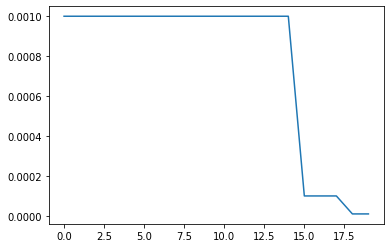

In [25]:
plt.plot(lrs)

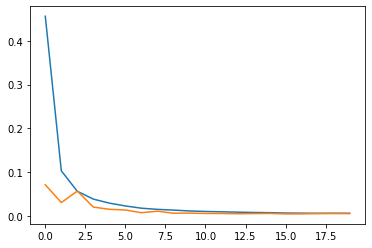

In [26]:
plt.plot(train_losses)
plt.plot(test_losses)

In [27]:
torch.save(best_weights, 'best_weights.pth')
model = StockPredictor(config, cat_dict).to(device)
model.load_state_dict(torch.load('best_weights.pth'))
model.eval()

StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(6, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

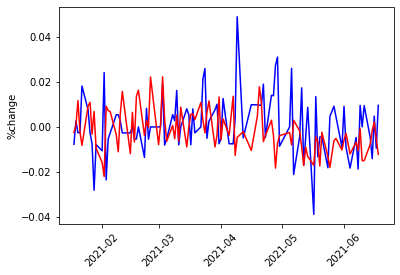

In [28]:
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
date_test = date_all[split:]

_=plt.plot(date_test[-100:],inv_true_pct.cpu().detach().numpy()[-100:],'b')
_=plt.plot(date_test[-100:],inv_pred_pct.cpu().detach().numpy()[-100:],'r')
_=plt.xticks(rotation=45)
_=plt.ylabel('%change')

In [29]:
print(seq_input)

tensor([[[0.3050, 0.2507, 0.2456, 0.1694, 0.4581, 0.3588],
         [0.3079, 0.3045, 0.2988, 0.1333, 0.4694, 0.4732],
         [0.2991, 0.2925, 0.2988, 0.0616, 0.4609, 0.3839],
         ...,
         [0.3284, 0.3045, 0.3284, 0.1178, 0.4859, 0.3108],
         [0.3372, 0.3224, 0.3225, 0.0866, 0.5236, 0.5870],
         [0.3372, 0.3224, 0.3373, 0.1073, 0.5091, 0.3609]],

        [[0.3079, 0.3045, 0.2988, 0.1333, 0.4694, 0.4732],
         [0.2991, 0.2925, 0.2988, 0.0616, 0.4609, 0.3839],
         [0.2551, 0.1791, 0.2574, 0.1836, 0.3675, 0.0000],
         ...,
         [0.3372, 0.3224, 0.3225, 0.0866, 0.5236, 0.5870],
         [0.3372, 0.3224, 0.3373, 0.1073, 0.5091, 0.3609],
         [0.3255, 0.3164, 0.3136, 0.0536, 0.5004, 0.3847]],

        [[0.2991, 0.2925, 0.2988, 0.0616, 0.4609, 0.3839],
         [0.2551, 0.1791, 0.2574, 0.1836, 0.3675, 0.0000],
         [0.2405, 0.0985, 0.1420, 0.2381, 0.3816, 0.4934],
         ...,
         [0.3372, 0.3224, 0.3373, 0.1073, 0.5091, 0.3609],
         [

In [30]:
# convert to price plot
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
# to get real price is to multiply the predicted % with previous day close price


prev_day_close = seq_input[:,-1,-2]*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']


pred_price = (1+inv_pred_pct.view(-1,))*prev_day_close

inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
true_price = (1+inv_true_pct.view(-1,))*prev_day_close

In [31]:
yeah = (max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
yeah

474.0

In [32]:
prev_day_close[-1]

tensor(418., device='cuda:0')

In [33]:
print(seq_input[:,-1,-2])

tensor([0.5091, 0.5004, 0.5265, 0.5207, 0.5120, 0.5323, 0.5583, 0.5612, 0.5786,
        0.5554, 0.5380, 0.5496, 0.5583, 0.5670, 0.5612, 0.5641, 0.5496, 0.5583,
        0.5757, 0.5815, 0.5786, 0.5641, 0.5699, 0.5670, 0.5641, 0.5409, 0.5699,
        0.5641, 0.5988, 0.6191, 0.6422, 0.6278, 0.6393, 0.6538, 0.6307, 0.6133,
        0.6046, 0.6220, 0.6307, 0.6220, 0.6133, 0.6075, 0.6162, 0.5988, 0.6220,
        0.6422, 0.6336, 0.6422, 0.6538, 0.7059, 0.7059, 0.6770, 0.6741, 0.6828,
        0.6857, 0.6799, 0.6885, 0.6943, 0.6914, 0.6914, 0.7059, 0.7059, 0.6972,
        0.7001, 0.6828, 0.6857, 0.6625, 0.6828, 0.6567, 0.6480, 0.6741, 0.6741,
        0.6683, 0.6712, 0.6625, 0.6669, 0.6463, 0.6581, 0.6698, 0.6463, 0.6287,
        0.6317, 0.6375, 0.6228, 0.6082, 0.5993, 0.5847, 0.6170, 0.6258, 0.6610,
        0.6610, 0.6581, 0.6493, 0.6023, 0.5964, 0.5935, 0.5876, 0.5876, 0.5758,
        0.5729, 0.5494, 0.5465, 0.5494, 0.5259, 0.5200, 0.5288, 0.5288, 0.5230,
        0.5670, 0.5670, 0.5670, 0.5964, 

In [34]:
target

tensor([[0.3847],
        [0.5344],
        [0.3976],
        [0.3852],
        [0.5083],
        [0.5307],
        [0.4337],
        [0.4923],
        [0.3297],
        [0.3511],
        [0.4700],
        [0.4575],
        [0.4572],
        [0.3986],
        [0.4336],
        [0.3634],
        [0.4575],
        [0.4925],
        [0.4450],
        [0.4104],
        [0.3643],
        [0.4453],
        [0.4103],
        [0.4102],
        [0.3283],
        [0.5417],
        [0.3986],
        [0.5623],
        [0.5010],
        [0.5105],
        [0.3677],
        [0.4659],
        [0.4762],
        [0.3361],
        [0.3562],
        [0.3885],
        [0.4893],
        [0.4550],
        [0.3890],
        [0.3888],
        [0.3996],
        [0.4555],
        [0.3552],
        [0.5123],
        [0.4992],
        [0.3894],
        [0.4547],
        [0.4653],
        [0.6149],
        [0.4219],
        [0.3196],
        [0.4114],
        [0.4535],
        [0.4323],
        [0.4011],
        [0

In [35]:
print(max_dict)

{'High': 554.0, 'Low': 546.0, 'Open': 550.0, 'Volume': 41989400.0, 'Adj Close': 474.0, 'pct_change': 0.14492769415845852}


In [36]:
print(min_dict)

{'High': 213.0, 'Low': 211.0, 'Open': 212.0, 'Volume': 0.0, 'Adj Close': 140.8712615966797, 'pct_change': -0.10576925568546891}


In [37]:
F.mse_loss(true_price,pred_price).sqrt()

tensor(6.2035, device='cuda:0', grad_fn=<SqrtBackward>)

In [38]:
pred_price

tensor([315.7643, 313.1681, 320.1658, 319.8506, 316.6090, 318.6299, 325.9766,
        330.6287, 337.4572, 329.8290, 322.8630, 325.7643, 328.2260, 332.6845,
        328.5596, 329.7252, 326.4924, 332.4225, 344.7545, 335.7686, 339.6806,
        336.5835, 339.9033, 331.6832, 333.0455, 320.3456, 329.2836, 333.5314,
        345.6342, 347.5995, 351.4211, 349.3342, 354.6127, 361.7313, 348.8647,
        346.5762, 348.9170, 349.4526, 353.7656, 353.8554, 349.1639, 351.2746,
        345.7159, 344.2416, 354.8065, 352.3011, 350.8605, 355.7761, 359.0938,
        376.5874, 378.4387, 364.6656, 365.3217, 373.2132, 372.7518, 369.3669,
        370.6210, 371.2920, 373.5300, 376.2055, 374.6693, 382.4960, 372.4407,
        374.6736, 368.5892, 368.7365, 365.1462, 369.2003, 363.0978, 356.9207,
        370.7257, 367.1239, 363.6576, 364.4538, 359.1755, 365.3150, 358.4402,
        360.1505, 366.1466, 357.5041, 350.0411, 349.2880, 357.0970, 354.1504,
        341.8683, 342.7302, 339.4126, 349.5226, 347.9612, 358.64

In [39]:
true_price

tensor([307.5745, 316.2522, 314.3238, 311.4313, 318.1806, 326.8582, 327.8224,
        333.6075, 325.8940, 320.1089, 323.9656, 326.8582, 329.7508, 327.8224,
        328.7866, 323.9656, 326.8582, 332.6433, 334.5717, 333.6075, 328.7866,
        330.7149, 329.7507, 328.7865, 321.0731, 330.7149, 328.7865, 340.3568,
        347.1060, 354.8195, 349.9986, 353.8553, 358.6763, 350.9628, 345.1777,
        342.2851, 348.0702, 350.9627, 348.0702, 345.1777, 343.2493, 346.1418,
        340.3568, 348.0702, 354.8195, 351.9270, 354.8195, 358.6763, 376.0316,
        376.0316, 366.3897, 365.4255, 368.3181, 369.2823, 367.3539, 370.2464,
        372.1748, 371.2106, 371.2106, 376.0316, 376.0316, 373.1390, 374.1031,
        368.3181, 369.2823, 361.5688, 368.3181, 359.6404, 356.7479, 365.4255,
        365.4255, 363.4972, 364.4614, 361.5688, 363.0366, 356.1869, 360.1010,
        364.0151, 356.1869, 350.3156, 351.2942, 353.2513, 348.3586, 343.4659,
        340.5303, 335.6376, 346.4015, 349.3371, 361.0796, 361.07

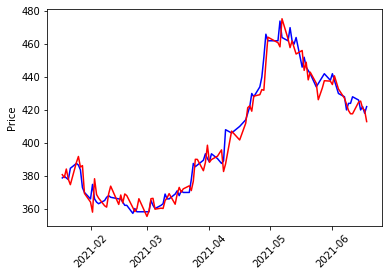

In [40]:
#graph of predicted and true closing price
_=plt.plot(date_test[-100:],true_price.cpu().detach().numpy()[-100:],'b') #True
_=plt.plot(date_test[-100:],pred_price.cpu().detach().numpy()[-100:],'r') #Predict
_=plt.xticks(rotation=45)
_=plt.ylabel('Price')

In [41]:
np.corrcoef(true_price.cpu().detach().numpy(),pred_price.cpu().detach().numpy())[0][1]

0.9858740219477286

# **Simulation**

In [42]:
cash = 1_000_000
port = 0
for pct_pred, pct_true in zip(inv_pred_pct.cpu().detach().numpy(),inv_true_pct.cpu().detach().numpy()):
  if pct_pred>0:
    #buy
    if port == 0:
      port=cash
      cash=0
  else:
    #sell
    if port != 0:
      cash=port
      port=0
  #realize
  if port != 0:
    port *= (1+pct_true)
  
equity = cash+port
print(equity)

[1369699.87019669]


In [43]:
min(date_test), max(date_test)

(Timestamp('2020-04-21 00:00:00'), Timestamp('2021-06-18 00:00:00'))

## the added stuff

In [44]:
#  df1 = stock_data[0]

In [45]:
# #SMA20 AKA simple moving average 20(days)
# for i in range(0,df1.shape[0]-19):
#     df1.loc[df1.index[i+19],'SMA_20'] = np.round(((df1.iloc[i,3]+ df1.iloc[i+1,3]    
#                                                  + df1.iloc[i+2,3] + df1.iloc[i+3,3] 
#                                                  + df1.iloc[i+4,3] + df1.iloc[i+5,3]
#                                                  + df1.iloc[i+6,3] + df1.iloc[i+7,3]
#                                                  + df1.iloc[i+8,3] + df1.iloc[i+9,3]
#                                                  + df1.iloc[i+10,3] + df1.iloc[i+11,3]
#                                                  + df1.iloc[i+12,3] + df1.iloc[i+13,3]
#                                                  + df1.iloc[i+14,3] + df1.iloc[i+15,3]
#                                                  + df1.iloc[i+16,3] + df1.iloc[i+17,3]
#                                                  + df1.iloc[i+18,3] + df1.iloc[i+19,3]
#                                                  )/20),1)

In [46]:
#  df1.tail(20)

In [47]:
#  df1[['Close','SMA_20']].plot()

In [48]:
# #comparing SMA price to current price to decide what to do
# if df1.iloc[-1,6] > df1.iloc[-1,3]:
#   print("Current price is below SMA20 might be a good time to buy and hold long")

# elif df1.iloc[-1,6] == df1.iloc[-1,3]:
#   print("Current price is exactly the same as SMA20 take a look at the day before to see if the price in coming from above or below ")

# else:
#   print("Current price is above SMA20 might want to wait a while before buying")
# print("SMA20 = ", df1.iloc[-1,6])
# print("Current price = ", df1.iloc[-1,3])